In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


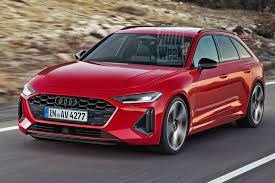

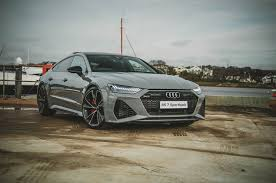

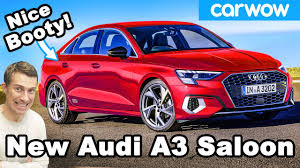

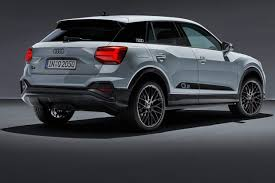

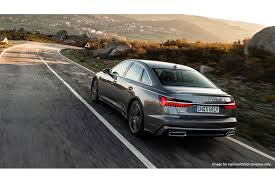

Found 199 images in the dataset directory.


In [2]:
import os
from IPython.display import display, Image

image_dir = '/content/drive/MyDrive/Dataset/Cars Dataset/test/Audi'

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
for i in range(min(5, len(image_files))): # Display at most 5 images
  image_path = os.path.join(image_dir, image_files[i])
  display(Image(filename=image_path))
print(f"Found {len(image_files)} images in the dataset directory.")

In [8]:
import os
from collections import defaultdict

def count_images_per_class(folder_path):
    class_counts = defaultdict(int)

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            count = len([
                fname for fname in os.listdir(class_folder)
                if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = count

    return dict(class_counts)

# Path ke folder train dan test
train_path = '/content/drive/MyDrive/Dataset/Cars Dataset/train'
test_path = '/content/drive/MyDrive/Dataset/Cars Dataset/test'

# Hitung jumlah gambar
train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

# Tampilkan hasil
print("Jumlah gambar per kelas (TRAIN):")
for k, v in train_counts.items():
    print(f"{k}: {v} gambar")

print("\nJumlah gambar per kelas (TEST):")
for k, v in test_counts.items():
    print(f"{k}: {v} gambar")

Jumlah gambar per kelas (TRAIN):
Mahindra Scorpio: 316 gambar
Hyundai Creta: 271 gambar
Audi: 814 gambar
Swift: 429 gambar
Toyota Innova: 775 gambar
Rolls Royce: 311 gambar
Tata Safari: 441 gambar

Jumlah gambar per kelas (TEST):
Mahindra Scorpio: 75 gambar
Tata Safari: 106 gambar
Hyundai Creta: 67 gambar
Toyota Innova: 190 gambar
Swift: 102 gambar
Audi: 199 gambar
Rolls Royce: 74 gambar


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import numpy as np

# 1. Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# 2. Konfigurasi dasar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_root = '/content/drive/MyDrive/Dataset/Cars Dataset'
train_dir = os.path.join(data_root, 'train')
test_dir = os.path.join(data_root, 'test')
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# 3. Transformasi gambar
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 4. Load dataset
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)
print("Detected Classes:", train_dataset.classes)

# 5. Load model ResNet18 dan ganti FC layer
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze fitur extractor

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# 6. Loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)

# 7. Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%")

# 8. Evaluasi model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

Detected Classes: ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]
Epoch 1/10: 100%|██████████| 105/105 [18:14<00:00, 10.42s/it]


Epoch [1/10], Loss: 1.4088, Accuracy: 52.37%


Epoch 2/10: 100%|██████████| 105/105 [06:31<00:00,  3.73s/it]


Epoch [2/10], Loss: 0.9220, Accuracy: 71.76%


Epoch 3/10: 100%|██████████| 105/105 [06:30<00:00,  3.72s/it]


Epoch [3/10], Loss: 0.7546, Accuracy: 77.99%


Epoch 4/10: 100%|██████████| 105/105 [06:31<00:00,  3.73s/it]


Epoch [4/10], Loss: 0.6554, Accuracy: 80.94%


Epoch 5/10: 100%|██████████| 105/105 [06:31<00:00,  3.73s/it]


Epoch [5/10], Loss: 0.5880, Accuracy: 82.48%


Epoch 6/10: 100%|██████████| 105/105 [06:33<00:00,  3.75s/it]


Epoch [6/10], Loss: 0.5557, Accuracy: 83.68%


Epoch 7/10: 100%|██████████| 105/105 [06:37<00:00,  3.78s/it]


Epoch [7/10], Loss: 0.5072, Accuracy: 84.87%


Epoch 8/10: 100%|██████████| 105/105 [06:30<00:00,  3.72s/it]


Epoch [8/10], Loss: 0.4938, Accuracy: 85.20%


Epoch 9/10: 100%|██████████| 105/105 [06:30<00:00,  3.72s/it]


Epoch [9/10], Loss: 0.4632, Accuracy: 85.67%


Epoch 10/10: 100%|██████████| 105/105 [06:29<00:00,  3.71s/it]


Epoch [10/10], Loss: 0.4467, Accuracy: 86.68%

Final Test Accuracy: 88.44%


In [ ]:
save_path = "/content/drive/MyDrive/Dataset/Cars Dataset/car_model_resnet18.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/Dataset/Cars Dataset/car_model_resnet18.pth


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/Dataset/Cars Dataset/car_model_resnet18.pth"

# Jumlah kelas (harus sama seperti waktu training)
num_classes =  len(os.listdir('/content/drive/MyDrive/Dataset/Cars Dataset/train'))  # atau tentukan manual

# Load model dan sesuaikan FC layer
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
from torchvision import transforms

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Ambil label kelas dari folder train
class_names = sorted(os.listdir('/content/drive/MyDrive/Dataset/Cars Dataset/train'))
print("Classes:", class_names)

Classes: ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


In [11]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        class_index = predicted.item()
        confidence = probs[0, class_index].item()

    # Tampilkan gambar dan prediksi
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[class_index]} ({confidence*100:.2f}%)")
    plt.axis("off")
    plt.show()

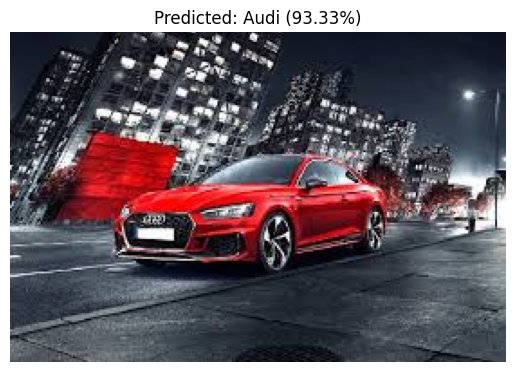

In [12]:
sample_image_path = '/content/drive/MyDrive/Dataset/Cars Dataset/test/Audi/1000.jpg'  # pastikan path dan ekstensi benar

predict_image(sample_image_path, model, transform_test, class_names)